First, install the necessary packages.

In [1]:
import sys
!{sys.executable} -m pip install --quiet numpy
!{sys.executable} -m pip install --quiet matplotlib
!{sys.executable} -m pip install --quiet wnutils

Now import the packages.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import wnutils.xml as wx
from matplotlib import animation 
from IPython.display import HTML

Define a routine to compute the proton separation energies (along with the proton number).  Sort by atomic number to ensure proper calculation of separation energies.

In [3]:
def calc_seps(proton, nuclides):
#    nm = []
    sep = []
    z = []
    m = []

    m_p = proton['h1']['mass excess']

    for sp in nuclides:
        m.append(nuclides[sp]['mass excess'])
        z.append(nuclides[sp]['z'])
        
    zipped_lists = zip(z, m)
    sorted_pairs = sorted(zipped_lists)

    tuples = zip(*sorted_pairs)
    z, m = [list(tuple) for tuple in tuples]

    for i in range(1, len(m)):
        sep.append(m[i-1] + m_p - m[i]) 
    
    return (z[1:len(z)], sep)

Now define a routine to compute the normalized $(p,\gamma)-(\gamma,p)$ equilibrium abundances for a given set of separation energies, and a given $\mu_p'$ and $T_9$.

In [4]:
def calc_y(Z, seps, mu_p_prime, T9):
    kT = T9 / 11.605
    y = []
    for i in range(len(seps)):
        if i == 0:
            y.append((seps[i] + mu_p_prime)/kT)
        else:
            y.append(y[i-1] + (seps[i] + mu_p_prime)/kT)
    ym = np.max(y)
    y -= ym 
    
    y = np.exp(y)
        
    return y / np.sum(y)

Retrieve the nuclear data from a webnucleo XML file.  The XML can be read over the web or from the local server (see the commented string for an example of the latter retrieval method).  Validate the XML to make sure it is well formed.

In [5]:
url_str = 'http://nucnet-tools.sf.net/data_pub/reaclib/my_net.xml'
#url_str = 'file://Users/bradleymeyer/Desktop/work/my-projects/nucnet-tools-code/data_pub/my_net.xml'

xml = wx.Xml(url_str)
xml.validate()

Select a neutron number.

In [6]:
N = 90

Create the plot of $S_p$ vs. $Z$ and the plot of the normalized $(p,\gamma)-(\gamma,p)$ equilibrium abundances $Y(Z)$ vs. $Z$.

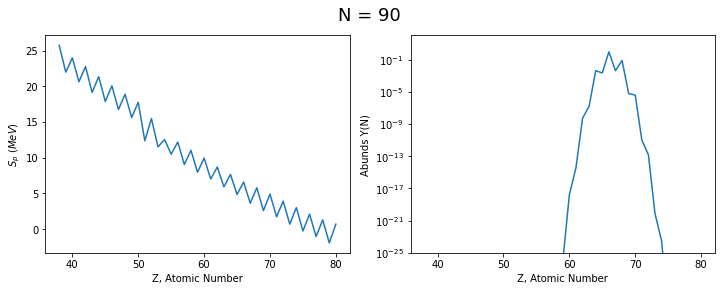

In [7]:
proton = xml.get_nuclide_data("[z = 1 and a = 1]")
nuclides = xml.get_nuclide_data('[a - z =' + str(N) + ']')
                                
if not nuclides:
    print('N = ' + str(N) + ' not present in nuclear data')
else:
    Z, seps = calc_seps(proton, nuclides)
    abunds = calc_y(N, seps, -5, 3)
    
fig, ax = plt.subplots(ncols = 2, figsize=(12,4))
fig.suptitle('N = ' + str(N), fontsize = 18)
ylabel = (('$S_p\ (MeV)$','Abunds Y(N)'))
data = np.array(list(zip(seps,abunds)))
ax[1].set_yscale('log')
ax[1].set_ylim(1.e-25,1.e2)

for i in range(2):
    ax[i].set_xlabel('Z, Atomic Number')
    ax[i].set_ylabel(ylabel[i])
    ax[i].plot(Z, data[:,i])

Now, create a new frame for the movie.

In [8]:
fig = plt.figure(figsize=(8,6))

ax1 = plt.subplot(211)

ax1.set_ylabel(r'Energy [MeV]')
ax1.set_xlim(np.min(Z)-3,np.max(Z)+3)
ax1.set_ylim([-5,30])
txt_title = ax1.set_title('',fontsize=10)
line1, = ax1.plot([], [], label = r'-$\mu_n^{\prime}$')
line2, = ax1.plot([], [], label = r'$S_p$')
ax1.legend()

ax2 = plt.subplot(212)

ax2.set_ylabel(r'Abunds ratio')
ax2.set_xlabel('Proton number N')
ax2.set_xlim([np.min(Z)-3,np.max(Z)+3])
ax2.set_ylim([1.e-20,1.e1])
ax2.set_yscale('log')
line3, = ax2.plot([], [], label = r'Abunds ratio')
plt.legend()
plt.close()

Create a movie to show the the effects of a changing temperature $T_9$ and a chaning $\mu_p'$

In [9]:
def make_movie(i):
    
    mp = -Mu_p[i]*np.ones(len(Z))
    t9 = T_9[i]
    for j in range(len(Mu_p)):
        abunds = np.zeros([len(Mu_p),len(Z)])
        abunds[i,:] = calc_y(Z, seps, Mu_p[i], t9)
    
    txt_title.set_text(r"N = {N};  $T_9$ = {T9};  $-\mu_p'$ = {mp} [MeV]".format(N = str(N),T9 = "%.1f" %T_9[i], mp = "%.1f" %Mu_p[i]))

    line1.set_data(Z, mp)
    line2.set_data(Z, seps)
    line3.set_data(Z, abunds[i,:])
    
    return (line1, line2, line3)

We first consider a varing $\mu_p'$ and a constand $T_9$.

In [10]:
Mu_p = np.linspace(-25,0,50)
T_9 = 3*np.ones(len(Mu_p)) 

#Mu_p = -10*np.ones(28) #for a constant mu_p_prime 
#T_9 = np.linspace(4,2,28) #for a decreasing temperature 

Now we can compare the intersection of $\mu_p'$ and $S_p$ and the peak in the normalized $(p,\gamma)-(\gamma,p)$ equilibrium abundances distribution.

In [11]:
args = (T_9, Mu_p)
anim = animation.FuncAnimation(fig, make_movie, frames=len(Mu_p), blit=True, repeat=False)
HTML(anim.to_jshtml())